In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize

In [4]:
# class RF:
#     def __init__(self,num_tree=10,max_depth=5,min_samples_split=2,sample_size=0.8,device="cuda"):
#         self.num_tree=num_tree
#         self.trees=[DT(max_depth=max_depth,min_samples_split=min_samples_split,device=device) for _ in range(num_tree)]
#         self.sample_size=sample_size
#         self.device=torch.device(device if torch.cuda.is_available() else "cpu")
    
#     def bs_sample(self,x,y):
#         n_samples=int(self.sample_size*len(x))
#         idx=np.random.choice(len(x),n_samples,replace=True)
#         return x[idx],y[idx]
    
#     def fit(self,x,y):
#         for tree in self.trees:
#             x_sample,y_sample=self.bs_sample(x,y)
#             tree.fit(x_sample,y_sample)
    
#     def predict(self,x):
#         preds=torch.stack([tree.predict(x) for tree in self.trees])
#         return torch.mode(preds, dim=0)[0]

# Importing

In [5]:
import numpy as np
import torch
from scipy.stats import mode


# Decision Tree Class

In [6]:
class DT:
    def __init__(self,max_depth=3,min_samples_split=5,device="cuda"):
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.device=torch.device(device if torch.cuda.is_available() else "cpu")
        self.tree=None

    def gini_impurity(self,y):
        _, counts=np.unique(y,return_counts=True)
        pi=counts/counts.sum()
        return 1-np.sum(pi**2)

    def best_split(self,x,y):
        m,n=x.shape
        best_gini,best_feature,best_cut=float("inf"),None,None
        
        for feature in range(n):
            thresholds=np.percentile(x[:,feature],[25,50,75])
            
            for threshold in thresholds:
                left_mask=x[:,feature]<=threshold
                right_mask=~left_mask
                
                if left_mask.sum()<self.min_samples_split or right_mask.sum()<self.min_samples_split:
                    continue
                gini=(left_mask.sum()*self.gini_impurity(y[left_mask])+right_mask.sum()*self.gini_impurity(y[right_mask]))/m
                
                if gini<best_gini:
                    best_gini,best_feature,best_cut=gini,feature,threshold
        return best_feature,best_cut



    def build_tree(self,x,y,depth=0):
        if depth>=self.max_depth or len(set(y.tolist()))==1:
            return torch.tensor(np.bincount(y).argmax(),device=self.device)

        feature,cut=self.best_split(x,y)
        
        if feature is None:
            return torch.tensor(np.bincount(y).argmax(),device=self.device)
        
        left_mask,right_mask=x[:,feature]<=cut,x[:,feature]>cut
        return {"feature": feature, "cut": cut,"left": self.build_tree(x[left_mask],y[left_mask],depth+1),"right": self.build_tree(x[right_mask], y[right_mask], depth + 1)}

    def fit(self,x,y):
        x,y=torch.tensor(x,dtype=torch.float32,device=self.device),torch.tensor(y,dtype=torch.int64,device=self.device)
        self.tree=self.build_tree(x.cpu().numpy(),y.cpu().numpy())

    def predict_one(self,x,node):
        if isinstance(node,torch.Tensor):
            return node
        return self.predict_one(x,node["left"] if x[node["feature"]]<=node["cut"] else node["right"])

    def predict(self,x):
        x=torch.tensor(x,dtype=torch.float32,device=self.device)
        return torch.tensor([self.predict_one(xi,self.tree) for xi in x.cpu().numpy()],device=self.device)

# Random forest class

In [7]:
class RF:
    def __init__(self,num_tree=3,max_depth=3,min_samples_split=5,device="cuda"):
        self.num_tree=num_tree
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.device=torch.device(device if torch.cuda.is_available() else "cpu")
        self.trees=[]

    def bs_sample(self,x,y):
        idx=np.random.choice(len(x),len(x),replace=True)
        return x[idx],y[idx]

    def fit(self,x,y):
        x,y=np.array(x),np.array(y)
        for _ in range(self.num_tree):
            x_bs,y_bs=self.bs_sample(x,y)
            tree=DT(self.max_depth,self.min_samples_split,device=self.device)
            tree.fit(x_bs,y_bs)
            self.trees.append(tree)

    def predict(self,x):
        x=torch.tensor(x,dtype=torch.float32,device=self.device)
        preds = torch.stack([tree.predict(x) for tree in self.trees])
        return torch.mode(preds,dim=0)[0]

# Outputs and data-loading

C:\Users\charu\AppData\Local\Temp\ipykernel_22092\4149935728.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x,dtype=torch.float32,device=self.device)


Random Forest Accuracy: 78.95%

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      8117
           1       1.00      0.88      0.94      3444
           2       0.59      0.54      0.56      3463

    accuracy                           0.79     15024
   macro avg       0.79      0.76      0.77     15024
weighted avg       0.79      0.79      0.79     15024



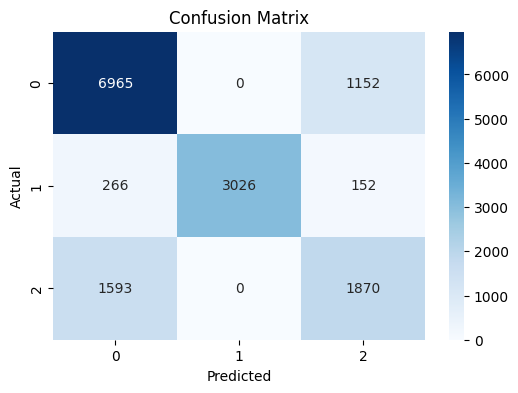

In [8]:
df=pd.read_csv("cleaned.csv")
X,y=df.drop(columns=["Diabetes_012"]).values,df["Diabetes_012"].values
np.random.seed(42)
indices=np.random.permutation(len(X))
split=int(0.8*len(X))
X_train,X_test,y_train,y_test=X[indices[:split]],X[indices[split:]],y[indices[:split]],y[indices[split:]]

rf=RF(num_tree=10,max_depth=10,min_samples_split=5)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test).cpu().numpy()

print(f"Random Forest Accuracy: {np.mean(y_pred==y_test)*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test,y_pred))

conf_matrix = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=np.unique(y),yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

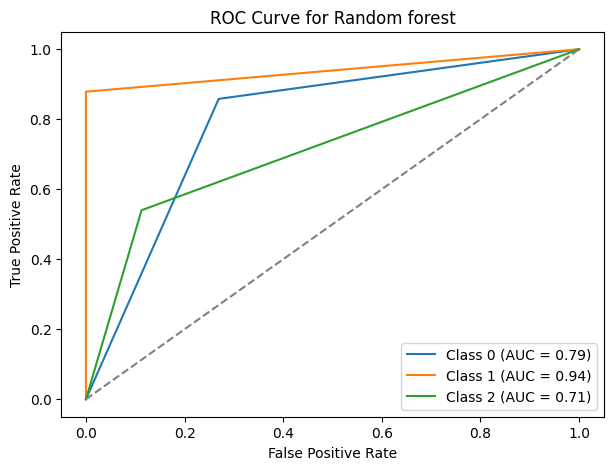

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score


y_test_bin=label_binarize(y_test,classes=[0,1,2])
y_pred_bin=label_binarize(y_pred,classes=[0,1,2])
n_classes=y_test_bin.shape[1]
plt.figure(figsize=(7,5))
for i in range(n_classes):
    fpr,tpr,_=roc_curve(y_test_bin[:,i],y_pred_bin[:,i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0,1],[0,1],linestyle='--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Random forest")
plt.legend()
plt.show()